In [41]:
import logging

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_moons
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader

from dal_toolbox import metrics
from dal_toolbox.active_learning import ActiveLearningDataModule
from dal_toolbox.active_learning.strategies import xpal
from dal_toolbox.datasets.utils import ContrastiveTransformations
from dal_toolbox.models.deterministic import simclr
from dal_toolbox.models.deterministic.simclr import InfoNCELoss
from dal_toolbox.models.parzen_window_classifier import PWCLightning
from dal_toolbox.models.utils.lr_scheduler import CosineAnnealingLRLinearWarmup
from dal_toolbox.utils import _calculate_mean_gamma, kernels

# configure logging at the root level of Lightning
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

In [42]:
# Settings
seed = 42
moon_noise = 0.07
transforms_noise = moon_noise / 5

# Building SIMCLR model
train_batch_size = 64
learning_rate = 0.01
weight_decay = 0.0
n_epochs = 100
temperature = 0.1
encoder = nn.Sequential(nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 32), nn.ReLU(), nn.Linear(32, 64), nn.ReLU())
projector = nn.Sequential(nn.Linear(64, 16))

# Active learning
n_init = 2
n_query = 1
n_cylce = 9

# Strategy
alpha = 1e-9

In [43]:
class GaussianNoiseTransform:
    def __init__(self, mean=0.0, std=1.0, random_seed=0):
        self.rng = np.random.default_rng(random_seed)
        self.mean = mean
        self.std = std

    def __call__(self, x):
        return x + torch.tensor(self.rng.normal(self.mean, self.std, size=x.shape), dtype=torch.float32)


class SKLearnDataset(Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transforms = transforms

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transforms is not None:
            x = self.transforms(x)

        return x, self.y[idx]

In [44]:
@torch.inference_mode()
def get_representations_and_labels(model, dataloader):
    all_features = []
    all_labels = []
    for batch in dataloader:
        features = batch[0]
        labels = batch[1]
        all_features.append(model(features))
        all_labels.append(labels)
    features = torch.cat(all_features)
    labels = torch.cat(all_labels)
    return features, labels

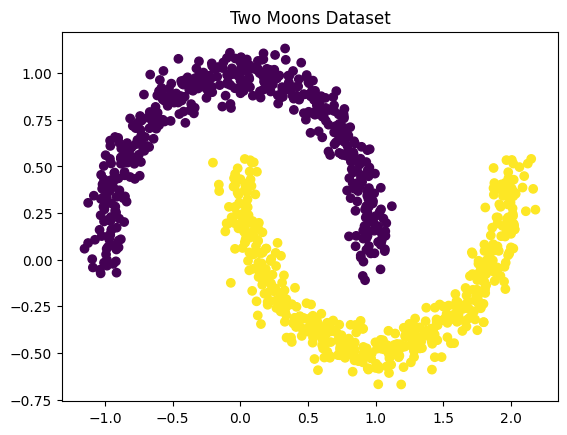

In [45]:
X, y = make_moons(1000, random_state=seed, noise=moon_noise)

plt.scatter(X[:, 0], X[:, 1], c=y, marker="o")
plt.title("Two Moons Dataset")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)

In [46]:
transform = ContrastiveTransformations(GaussianNoiseTransform(std=transforms_noise, random_seed=seed))

trainset = SKLearnDataset(X_train, y_train, transform)
valset = SKLearnDataset(X_val, y_val, transform)
testset = SKLearnDataset(X_test, y_test)

train_dataloader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=train_batch_size, shuffle=False)

In [47]:
optimizer = SGD(params=list(encoder.parameters()) + list(projector.parameters()),
                lr=learning_rate,
                weight_decay=weight_decay)

lr_scheduler = CosineAnnealingLRLinearWarmup(
    optimizer=optimizer,
    num_epochs=n_epochs,
    warmup_epochs=10
)

model = simclr.SimCLR(
    encoder=encoder,
    projector=projector,
    loss_fn=InfoNCELoss(temperature),
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    train_metrics={'train_acc_top1': metrics.ContrastiveAccuracy(),
                   'train_acc_top5': metrics.ContrastiveAccuracy(topk=5)},
    val_metrics={'val_acc_top1': metrics.ContrastiveAccuracy(),
                 'val_acc_top5': metrics.ContrastiveAccuracy(topk=5)}
)
model.encoder_output_dim = 64

trainer = L.Trainer(
    default_root_dir="SIMCLR_Two_Moons",
    accelerator="auto",
    max_epochs=n_epochs,
    check_val_every_n_epoch=25,
    enable_progress_bar=True,
)

In [48]:
trainer.fit(model, train_dataloader, val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

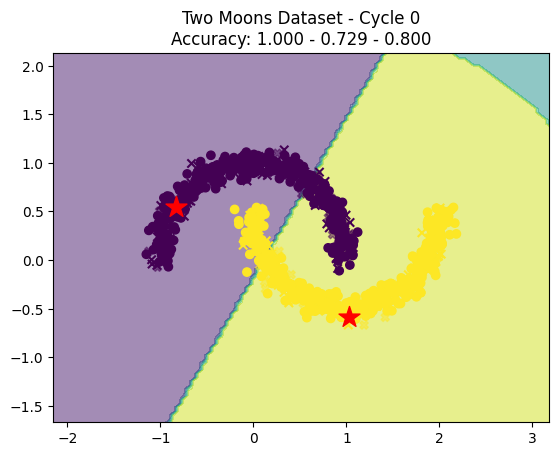

#decision_flips: 171245


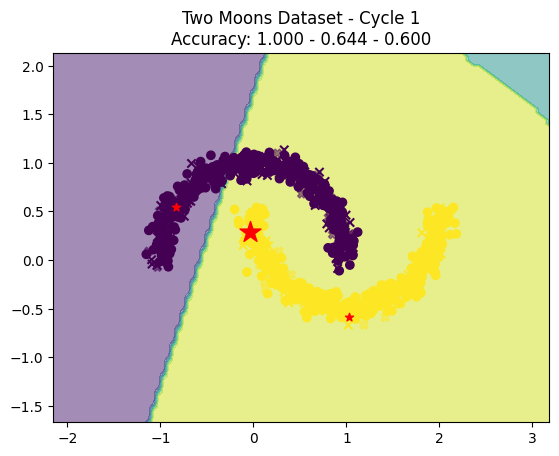

#decision_flips: 98231


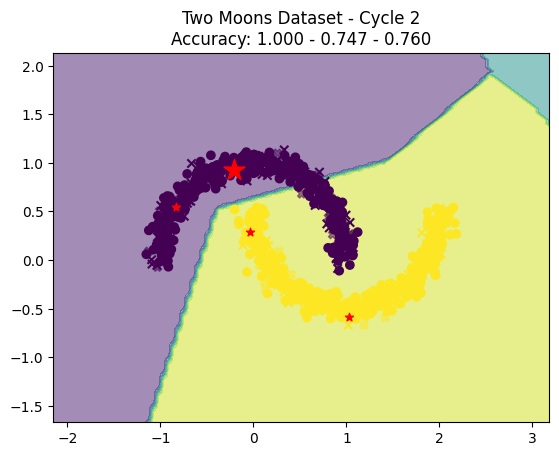

#decision_flips: 87017


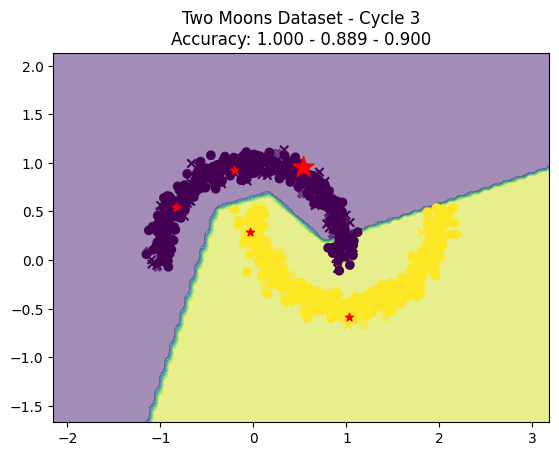

#decision_flips: 66105


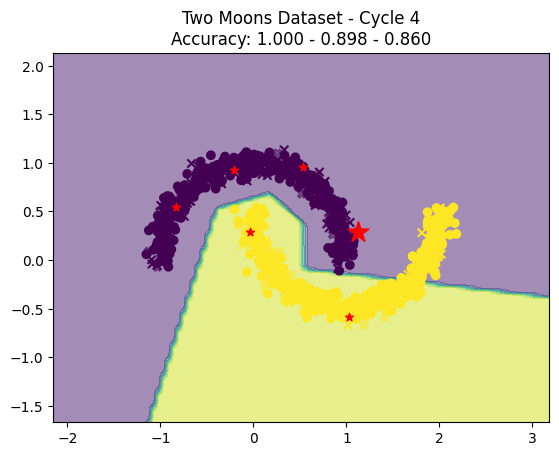

#decision_flips: 38869


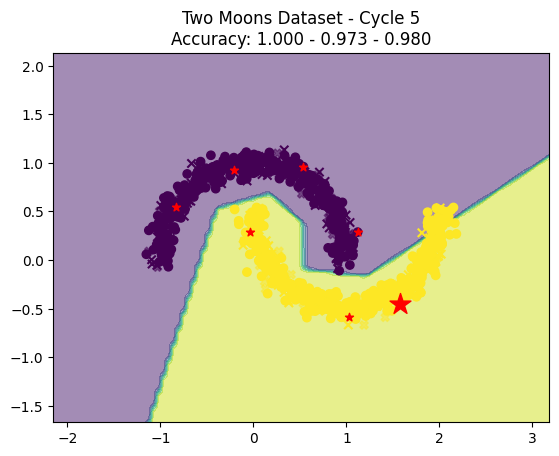

#decision_flips: 33838


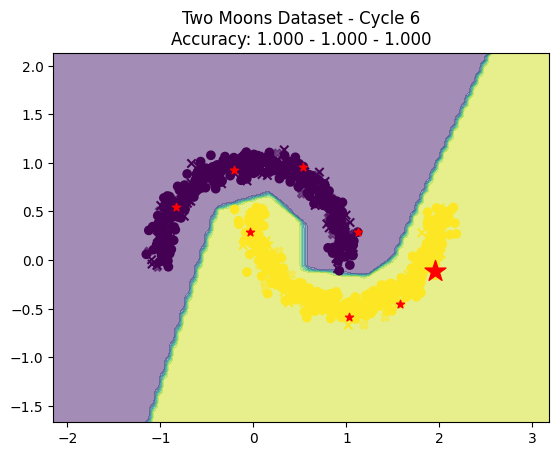

#decision_flips: 30283


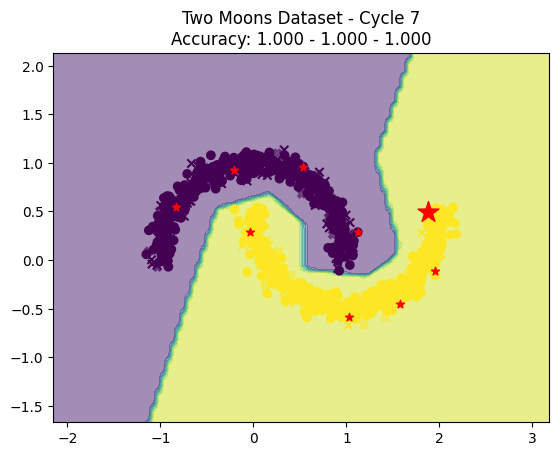

#decision_flips: 28450


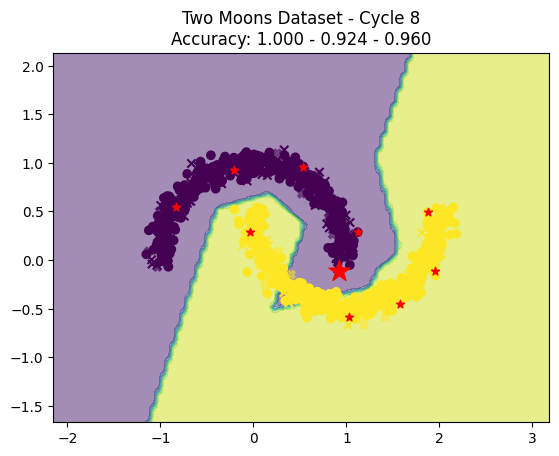

#decision_flips: 28459


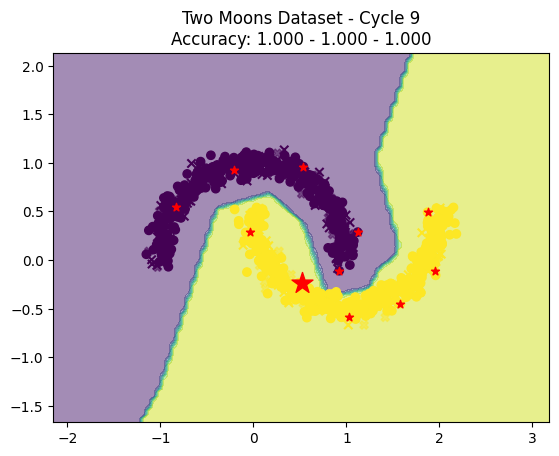

In [49]:
from dal_toolbox.utils import MetricLogger

results = {}
queried_indices = {}

# Get representations while ensuring ability to get representation back
trainset = SKLearnDataset(X_train, y_train)
valset = SKLearnDataset(X_val, y_val)
testset = SKLearnDataset(X_test, y_test)

train_dataloader = DataLoader(trainset, batch_size=512, shuffle=False)
val_dataloader = DataLoader(trainset, batch_size=512, shuffle=False)
test_dataloader = DataLoader(trainset, batch_size=512, shuffle=False)

train_features, train_labels = get_representations_and_labels(model.encoder, train_dataloader)
val_features, val_labels = get_representations_and_labels(model.encoder, val_dataloader)
test_features, test_labels = get_representations_and_labels(model.encoder, test_dataloader)

# AL Strategy
gamma = _calculate_mean_gamma(train_features)
S = kernels(X=train_features, Y=train_features, metric="rbf", gamma=gamma)
al_strategy = xpal.XPAL(2, S, subset_size=None, alpha_c=alpha, alpha_x=alpha, random_seed=seed)

# AL Model
kernel_params = {"kernel": {"name": "rbf", "gamma": gamma}, "n_neighbors": None}
al_model = PWCLightning(n_classes=2,
                        random_state=seed,
                        kernel_params=kernel_params,
                        train_metrics={'train_acc': metrics.Accuracy()},
                        val_metrics={'val_acc': metrics.Accuracy()})

# Setup AL Module
al_datamodule = ActiveLearningDataModule(
    train_dataset=trainset,
    val_dataset=valset,
    test_dataset=testset,
    train_batch_size=train_batch_size,
    predict_batch_size=512,
    seed=seed
)
al_datamodule.random_init(n_samples=n_init, class_balanced=True)
queried_indices['cycle0'] = al_datamodule.labeled_indices

# Active Learning Cycles
for i_acq in range(0, n_cylce + 1):
    cycle_results = {}

    if i_acq != 0:
        indices = al_strategy.query(
            model=al_model,
            al_datamodule=al_datamodule,
            acq_size=n_query
        )
        al_datamodule.update_annotations(indices)
        queried_indices[f'cycle{i_acq}'] = indices

    #  model cold start
    al_model.reset_states()

    # Train with updated annotations
    trainer = L.Trainer(
        max_epochs=2,
        enable_checkpointing=False,
        accelerator="cpu",
        default_root_dir="PWC_Two_Moons",
        enable_progress_bar=False,
        check_val_every_n_epoch=1,
    )
    trainer.fit(al_model, al_datamodule)

    # Evaluate resulting model
    predictions = trainer.predict(al_model, al_datamodule.train_dataloader())
    logits = torch.cat([pred[0] for pred in predictions])
    targets = torch.cat([pred[1] for pred in predictions])

    train_stats = {
        'accuracy': metrics.Accuracy()(logits, targets).item(),
        'nll': torch.nn.CrossEntropyLoss()(logits, targets).item(),
        'brier': metrics.BrierScore()(logits, targets).item(),
        'ece': metrics.ExpectedCalibrationError()(logits, targets).item(),
        'ace': metrics.AdaptiveCalibrationError()(logits, targets).item(),
    }
    train_accuracy = train_stats["accuracy"]

    predictions = trainer.predict(al_model, al_datamodule.val_dataloader())
    logits = torch.cat([pred[0] for pred in predictions])
    targets = torch.cat([pred[1] for pred in predictions])

    val_stats = {
        'accuracy': metrics.Accuracy()(logits, targets).item(),
        'nll': torch.nn.CrossEntropyLoss()(logits, targets).item(),
        'brier': metrics.BrierScore()(logits, targets).item(),
        'ece': metrics.ExpectedCalibrationError()(logits, targets).item(),
        'ace': metrics.AdaptiveCalibrationError()(logits, targets).item(),
    }
    val_accuracy = val_stats["accuracy"]

    predictions = trainer.predict(al_model, al_datamodule.test_dataloader())
    logits = torch.cat([pred[0] for pred in predictions])
    targets = torch.cat([pred[1] for pred in predictions])

    test_stats = {
        'accuracy': metrics.Accuracy()(logits, targets).item(),
        'nll': torch.nn.CrossEntropyLoss()(logits, targets).item(),
        'brier': metrics.BrierScore()(logits, targets).item(),
        'ece': metrics.ExpectedCalibrationError()(logits, targets).item(),
        'ace': metrics.AdaptiveCalibrationError()(logits, targets).item(),
    }
    test_accuracy = test_stats["accuracy"]

    cycle_results.update({
        "test_stats": test_stats,
        "labeled_indices": al_datamodule.labeled_indices,
        "n_labeled_samples": len(al_datamodule.labeled_indices),
        "unlabeled_indices": al_datamodule.unlabeled_indices,
        "n_unlabeled_samples": len(al_datamodule.unlabeled_indices),
    })
    results[f'cycle{i_acq}'] = cycle_results

    ind = queried_indices[f'cycle{i_acq}']
    queried_sample_cycle = X_train[ind]

    queried_samples = X_train[[item for sublist in [value for value in queried_indices.values()] for item in sublist]]

    # Deciscion Boundary
    DecisionBoundaryDisplay.from_estimator(al_model.model, X, response_method="predict_proba", alpha=0.5)

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker="o")
    plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, marker="x")
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker="X", alpha=0.5)
    plt.scatter(queried_samples[:, 0], queried_samples[:, 1], c="red", marker='*')
    plt.scatter(queried_sample_cycle[:, 0], queried_sample_cycle[:, 1], c="red", marker='*', s=250)
    plt.title(f"Two Moons Dataset - Cycle {i_acq}\nAccuracy: {train_accuracy:.3f} - {val_accuracy:.3f} - {test_accuracy:.3f}")
    plt.show()